In [506]:
require(data.table)
require(ggplot2)
require(survival)
library(cobs)     # Package for constrained L1 B-splines

In [463]:
path = '/Users/davide/Documents/universita/tesi/src/pharmacological_counting_process'
setwd(path)
source('compute_cumulative_hazards.R')
load('../../data/preprocessed_data.RData')

In [290]:
head(sel_df, n = 8)

id,start,stop,status,sex,age_in,Nm,sum_past_qt_prest
10000717,-0.5,101.0,1,M,72,0,0
10000717,101.0,130.0,1,M,72,1,56
10000717,130.0,176.0,1,M,72,2,112
10000717,176.0,197.0,1,M,72,3,168
10000717,197.0,212.0,1,M,72,4,182
10000717,212.0,247.0,1,M,72,5,238
10000717,247.0,344.0,1,M,72,6,350
10000717,344.0,365.5,0,M,72,7,406


# Extended Cox model (recurrent events, time varying features)

In [547]:
model = coxph(Surv(start,stop,status)~ age_in  + Nm + cluster(id), data = sel_df)

## Evaluate goodness of fit

In [548]:
# TODO

## Compute and smooth baseline Hazards

In [549]:
# get baseline
bh = basehaz(model, centered = FALSE)

t <- bh$time
Lambda0 <- bh$hazard

In [550]:
# Smooth version of Lambda0
Lambda0S <- cobs(t,Lambda0,constraint=c("increase"),pointwise=matrix(c(0,0,0),nrow=1),nknots=20,lambda=0,toler.kn=0)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


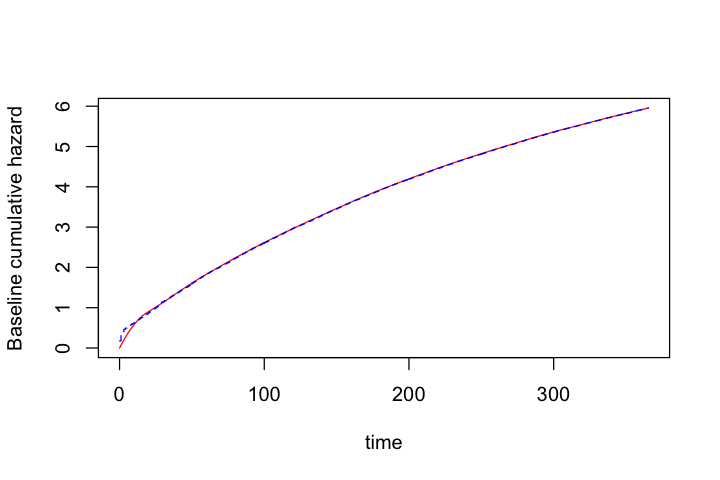

In [551]:
# Comparison between basic and smooth estimate
plot(Lambda0S$x,Lambda0S$fitted,type="l",main="",ylab="Baseline cumulative hazard",xlab="time", col = 'red')
points(t,Lambda0,type="s",lty=2, col = 'blue')

## Reconstruct patients cumulative Hazards

In [ ]:
# We evaluate cumulative hazards in a grid of days 
times <- seq(0,365,by=1)
cumulative_hazard = compute_cumulative_hazard(model,sel_df,Lambda0S,times,verbose = TRUE)

[1] "Computing coefficients ck"
  |=====                                                                 |   7%

In [ ]:
head(cumulative_hazard)

In [ ]:
# plot
ggplot(cumulative_hazard, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_line(data = bh, aes(x= time, y=hazard), color = 'black') +
    ggtitle(expression(Lambda[i](t))) +
    theme(legend.position="none")

In [ ]:
# save
save(cumulative_hazard, file = '../../data/cumulative_hazards.RData')

## Check Martingale residuals

In [536]:
# TODO